In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.io import fits
from scipy.ndimage import gaussian_filter

In [3]:
qsolist = fits.open('/content/drive/MyDrive/Hands on Sessions/HoS4/MAGG_spectra_merged.fits')
num_qso = len(qsolist) - 1

lae = Table.read('/content/drive/MyDrive/Hands on Sessions/HoS4/MAGG_LAEs.fits')


In [4]:
v_bins = np.linspace(-1000,1000,50)
r_bins = np.linspace(0,450,50)

lambda_lya = 1215.67
c = 299792.458

In [5]:
optical_depth_map = np.zeros((len(r_bins)-1, len(v_bins)-1))
count_map = np.zeros_like(optical_depth_map)

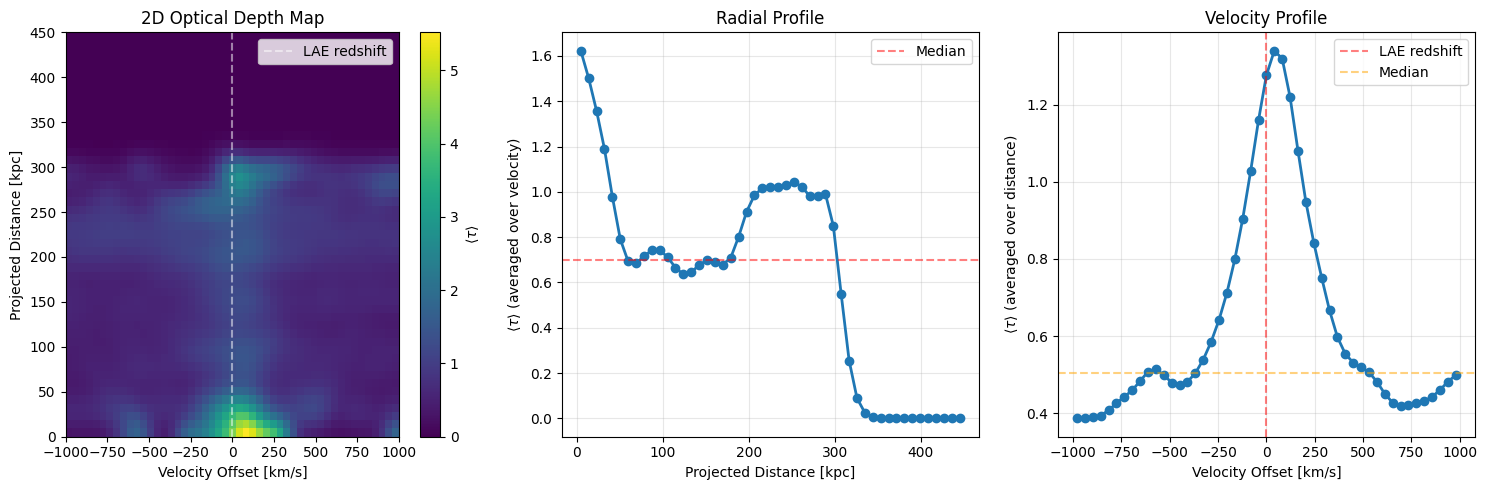

In [6]:
for i in range(1, num_qso + 1):

    field_name = qsolist[i].name

    data = qsolist[i].data
    wave = data['wave']
    flux = data['flux']

    z_qso = wave[-1] / lambda_lya - 1
    z_lya = wave / lambda_lya - 1

    mask = z_lya < z_qso
    wave_masked = wave[mask]
    flux_masked = flux[mask]
    z_lya_masked = z_lya[mask]

    flux_safe = np.clip(flux_masked, 1e-5, None)
    tau = -np.log(flux_safe)

    lae_fields = np.array([f.decode() if isinstance(f, bytes) else f for f in lae['FIELD']])
    mask_field = (lae_fields == field_name)
    lae_field = lae[mask_field]

    if len(lae_field) == 0:
        continue

    for j in lae_field:
      z_lae = j['z_corr']
      r_kpc = j['R_kpc']


      velocity = c * (z_lya_masked - z_lae) / (1 + z_lae)


      for v_val, tau_val in zip(velocity, tau):
        i_r = np.digitize(r_kpc, r_bins) - 1
        i_v = np.digitize(v_val, v_bins) - 1
        if 0 <= i_r < len(r_bins)-1 and 0 <= i_v < len(v_bins)-1:
          if np.isfinite(tau_val):
            optical_depth_map[i_r, i_v] += tau_val
            count_map[i_r, i_v] += 1


tau_map_mean = np.divide(optical_depth_map, count_map,
                         out=np.zeros_like(optical_depth_map),
                         where=count_map!=0)

tau_map_smooth = gaussian_filter(tau_map_mean, sigma=1.5)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 2D map
v_centers = (v_bins[:-1] + v_bins[1:]) / 2
r_centers = (r_bins[:-1] + r_bins[1:]) / 2

im = axes[0].pcolormesh(v_centers, r_centers, tau_map_smooth, cmap='viridis', shading='auto')
axes[0].axvline(0, color='white', linestyle='--', alpha=0.5, label='LAE redshift')
axes[0].set_xlabel('Velocity Offset [km/s]')
axes[0].set_ylabel('Projected Distance [kpc]')
axes[0].set_title('2D Optical Depth Map')
axes[0].legend()
plt.colorbar(im, ax=axes[0], label=r'$\langle \tau \rangle$')

# Radial profile
tau_radial = np.nanmean(tau_map_smooth, axis=1)
axes[1].plot(r_centers, tau_radial, 'o-', linewidth=2, markersize=6)
axes[1].axhline(np.nanmedian(tau_radial), color='red', linestyle='--', alpha=0.5, label='Median')
axes[1].set_xlabel('Projected Distance [kpc]')
axes[1].set_ylabel(r'$\langle \tau \rangle$ (averaged over velocity)')
axes[1].set_title('Radial Profile')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

# Velocity profile
tau_velocity = np.nanmean(tau_map_smooth, axis=0)
axes[2].plot(v_centers, tau_velocity, 'o-', linewidth=2, markersize=6)
axes[2].axvline(0, color='red', linestyle='--', alpha=0.5, label='LAE redshift')
axes[2].axhline(np.nanmedian(tau_velocity), color='orange', linestyle='--', alpha=0.5, label='Median')
axes[2].set_xlabel('Velocity Offset [km/s]')
axes[2].set_ylabel(r'$\langle \tau \rangle$ (averaged over distance)')
axes[2].set_title('Velocity Profile')
axes[2].grid(True, alpha=0.3)
axes[2].legend()

plt.tight_layout()
plt.show()

In [8]:
# Task 3: Statistical Significance Test

n_iterations = 1

random_maps = np.zeros((n_iterations, len(r_bins)-1, len(v_bins)-1))

for iteration in range(n_iterations):

    optical_depth_random = np.zeros((len(r_bins)-1, len(v_bins)-1))
    count_random = np.zeros_like(optical_depth_random)

    # Loop through quasars
    for i in range(1, num_qso + 1):
        field_name = qsolist[i].name
        data = qsolist[i].data
        wave = data['wave']
        flux = data['flux']

        z_qso = wave[-1] / lambda_lya - 1
        z_lya = wave / lambda_lya - 1

        mask = z_lya < z_qso
        wave_masked = wave[mask]
        flux_masked = flux[mask]
        z_lya_masked = z_lya[mask]

        flux_safe = np.clip(flux_masked, 1e-5, None)
        tau = -np.log(flux_safe)

        # Get LAEs for this field
        lae_fields = np.array([f.decode() if isinstance(f, bytes) else f for f in lae['FIELD']])
        mask_field = (lae_fields == field_name)
        lae_field = lae[mask_field]

        if len(lae_field) == 0:
            continue

        # RANDOMIZE: Shuffle LAE redshifts within this field
        z_lae_random = np.random.permutation(lae_field['z_corr'])

        for j, lae_entry in enumerate(lae_field):
            z_lae = z_lae_random[j]
            r_kpc = lae_entry['R_kpc']

            velocity = c * (z_lya_masked - z_lae) / (1 + z_lae)

            for v_val, tau_val in zip(velocity, tau):
                i_r = np.digitize(r_kpc, r_bins) - 1
                i_v = np.digitize(v_val, v_bins) - 1
                if 0 <= i_r < len(r_bins)-1 and 0 <= i_v < len(v_bins)-1:
                    if np.isfinite(tau_val):
                        optical_depth_random[i_r, i_v] += tau_val
                        count_random[i_r, i_v] += 1

    tau_random = np.divide(optical_depth_random, count_random,
                          out=np.zeros_like(optical_depth_random),
                          where=count_random!=0)

    random_maps[iteration] = gaussian_filter(tau_random, sigma=1.5)

print("Randomization complete!")

tau_random_mean = np.mean(random_maps, axis=0)
tau_random_std = np.std(random_maps, axis=0)

# Calculate Signal-to-Noise Ratio
snr_map = np.divide(tau_map_smooth - tau_random_mean, tau_random_std,
                   out=np.zeros_like(tau_map_smooth),
                   where=tau_random_std > 0)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

v_centers = (v_bins[:-1] + v_bins[1:]) / 2
r_centers = (r_bins[:-1] + r_bins[1:]) / 2

im1 = axes[0, 0].pcolormesh(v_centers, r_centers, tau_map_smooth,
                            cmap='viridis', shading='auto')
axes[0, 0].axvline(0, color='white', linestyle='--', alpha=0.5)
axes[0, 0].set_xlabel('Velocity Offset [km/s]')
axes[0, 0].set_ylabel('Projected Distance [kpc]')
axes[0, 0].set_title('Real Signal')
plt.colorbar(im1, ax=axes[0, 0], label=r'$\langle \tau \rangle$')

# 2. Random background
im2 = axes[0, 1].pcolormesh(v_centers, r_centers, tau_random_mean,
                            cmap='viridis', shading='auto')
axes[0, 1].axvline(0, color='white', linestyle='--', alpha=0.5)
axes[0, 1].set_xlabel('Velocity Offset [km/s]')
axes[0, 1].set_ylabel('Projected Distance [kpc]')
axes[0, 1].set_title('Random Background')
plt.colorbar(im2, ax=axes[0, 1], label=r'$\langle \tau \rangle$')

# 3. SNR map
im3 = axes[0, 2].pcolormesh(v_centers, r_centers, snr_map,
                            cmap='RdBu_r', vmin=-4, vmax=4, shading='auto')
axes[0, 2].contour(v_centers, r_centers, snr_map, levels=[2], colors='green', linewidths=2)
axes[0, 2].contour(v_centers, r_centers, snr_map, levels=[-2], colors='purple', linewidths=2)
axes[0, 2].axvline(0, color='black', linestyle='--', alpha=0.5)
axes[0, 2].set_xlabel('Velocity Offset [km/s]')
axes[0, 2].set_ylabel('Projected Distance [kpc]')
axes[0, 2].set_title('Signal-to-Noise Ratio (SNR)\nGreen=+2σ, Purple=-2σ')
plt.colorbar(im3, ax=axes[0, 2], label='SNR')

tau_radial_real = np.nanmean(tau_map_smooth, axis=1)
tau_radial_random = np.nanmean(tau_random_mean, axis=1)
axes[1, 0].plot(r_centers, tau_radial_real, 'o-', linewidth=2,
               label='Real Signal', color='blue')
axes[1, 0].plot(r_centers, tau_radial_random, 's--', linewidth=2,
               label='Random', color='red')
axes[1, 0].set_xlabel('Projected Distance [kpc]')
axes[1, 0].set_ylabel(r'$\langle \tau \rangle$')
axes[1, 0].set_title('Radial Profile Comparison')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

tau_velocity_real = np.nanmean(tau_map_smooth, axis=0)
tau_velocity_random = np.nanmean(tau_random_mean, axis=0)
axes[1, 1].plot(v_centers, tau_velocity_real, 'o-', linewidth=2,
               label='Real Signal', color='blue')
axes[1, 1].plot(v_centers, tau_velocity_random, 's--', linewidth=2,
               label='Random', color='red')
axes[1, 1].axvline(0, color='black', linestyle='--', alpha=0.5)
axes[1, 1].set_xlabel('Velocity Offset [km/s]')
axes[1, 1].set_ylabel(r'$\langle \tau \rangle$')
axes[1, 1].set_title('Velocity Profile Comparison')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

snr_radial = np.nanmean(snr_map, axis=1)
axes[1, 2].plot(r_centers, snr_radial, 'o-', linewidth=2, color='black')
axes[1, 2].axhline(2, color='green', linestyle='--', label='2σ threshold')
axes[1, 2].axhline(-2, color='purple', linestyle='--')
axes[1, 2].axhline(0, color='gray', linestyle='-', alpha=0.3)
axes[1, 2].set_xlabel('Projected Distance [kpc]')
axes[1, 2].set_ylabel('SNR')
axes[1, 2].set_title('Radial Signal-to-Noise')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Maximum SNR: {np.nanmax(snr_map):.2f}")
print(f"Minimum SNR: {np.nanmin(snr_map):.2f}")
print(f"Number of pixels with SNR > 2σ: {np.sum(snr_map > 2)}")
print(f"Number of pixels with SNR > 3σ: {np.sum(snr_map > 3)}")
print(f"Fraction of significant pixels (>2σ): {100*np.sum(snr_map > 2)/snr_map.size:.1f}%")

KeyboardInterrupt: 